In [1]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.io import read_image

from grenolnet.diffusion import DiffusionBase

In [2]:
def image_transform(img):
    img = torch.clamp(img, 0.0, 1.0).permute(1, 2, 0) * 255.0
    return img.cpu().detach().numpy().astype(np.uint8)

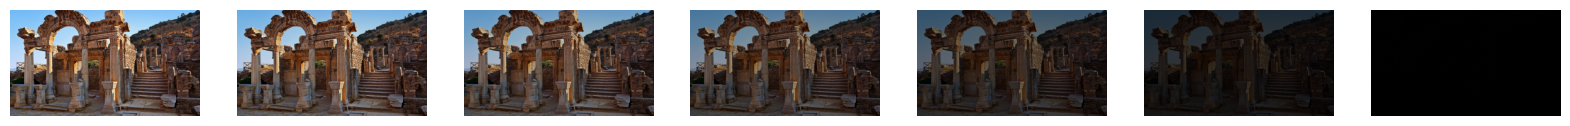

In [3]:
org_img = read_image("./Ephesus.jpg").float() / 255.0
diffuser = DiffusionBase(
    step_count=7,
    noise_schedule="cosine",
    noise_dist="normal",
    noise_mean=0.0,
    noise_std=0.01,
    noise_max=1.0,
)
noisy_imgs, noise = diffuser.q_sample(org_img.to("cuda"))
noisy_imgs = noisy_imgs.permute(3, 0, 1, 2)
plt.figure(figsize=(20, 140))
for img_idx, noisy_img in enumerate(noisy_imgs):
    ax = plt.subplot(1, 7, img_idx + 1)
    ax.set_axis_off()
    plt.imshow(image_transform(noisy_img))
plt.show()

torch.Size([3, 1080, 1920])


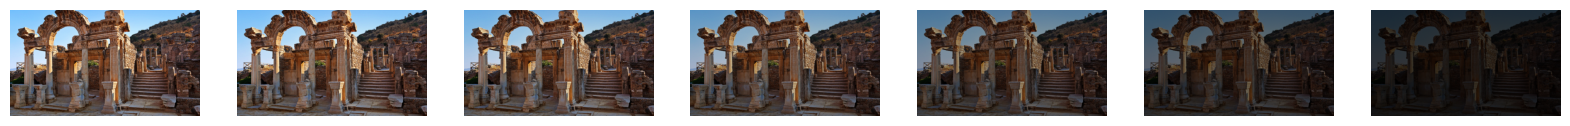

In [4]:
print(noise.shape)

img = noisy_imgs[-1]
plt.figure(figsize=(20, 140))
for i in range(7)[::-1]:
    timestep = torch.full((1,), i, device="cuda", dtype=torch.long)
    img = diffuser.p_sample(img, noise, noise, timestep)
    ax = plt.subplot(1, 7, i + 1)
    ax.set_axis_off()
    plt.imshow(image_transform(img))
plt.show()

In [5]:
from torchvision.utils import save_image

save_image(img, "Ephesus_denoised.jpg")

In [21]:
import matplotlib.pyplot as plt
import torch
from avicortex.datasets import CandiShareSchizophreniaDataset
from torch_geometric.loader import DataLoader

from grenolnet.diffusion import GraphDiffusion
from grenolnet.plotting import plot_graph_adjacency

torch.manual_seed(0)
STEP_COUNT = 50

tr_dataset_candi = CandiShareSchizophreniaDataset(
    hemisphere="right",
    freesurfer_out_path="../datasets/candishare_schizophrenia_dktatlas.csv",
    mode="train",
    n_folds=5,
    src_view_idx=2,
    tgt_view_idx=0,
)
tr_dataloader = DataLoader(tr_dataset_candi, batch_size=5)
diff_model = GraphDiffusion(
    step_count=STEP_COUNT,
    noise_schedule="cosine",
    noise_dist="normal",
    noise_mean=0.1,
    noise_std=0.01,
)

g_source, g_target = next(iter(tr_dataloader))

Hem:rh, Edges found: (34, 34, 94, 5)
Hem:rh, Nodes found: (34, 94, 5)
Hem:rh, Edges found: (34, 34, 94, 5)
Hem:rh, Nodes found: (34, 94, 5)


/tmp/ipykernel_11607/2317048542.py:12: DeprecationWarning: freesurfer_out_path is deprecated, use src_atlas_path and tgt_atlas_path instead.
  tr_dataset_candi = CandiShareSchizophreniaDataset(


DataDataBatch(x=[5, 34, 1], edge_index=[2, 5780], edge_attr=[5, 1156, 1], batch=[5], ptr=[6])


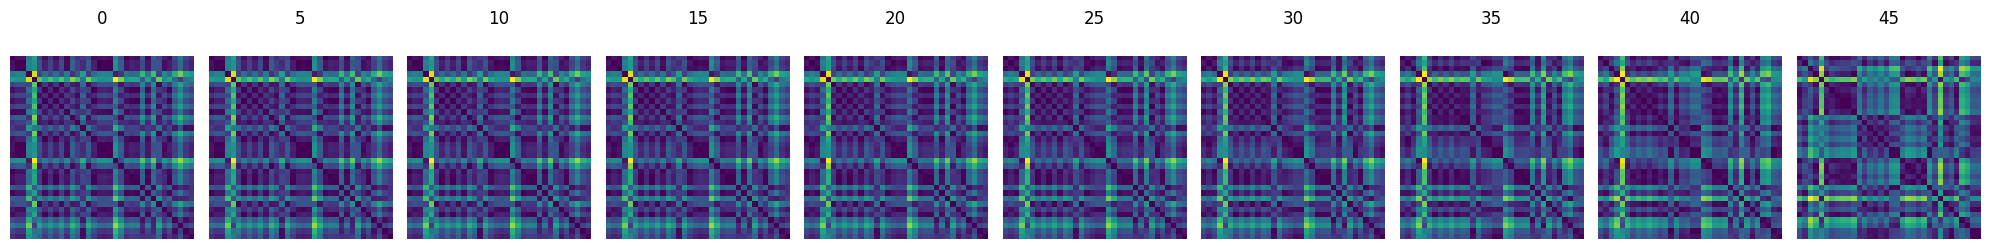

Data(x=[1, 34, 1], edge_index=[2, 1156], edge_attr=[1, 1156, 1])
DataDataBatch(x=[1, 34, 1], edge_index=[2, 1156], edge_attr=[1, 1156, 1], batch=[1], ptr=[2])


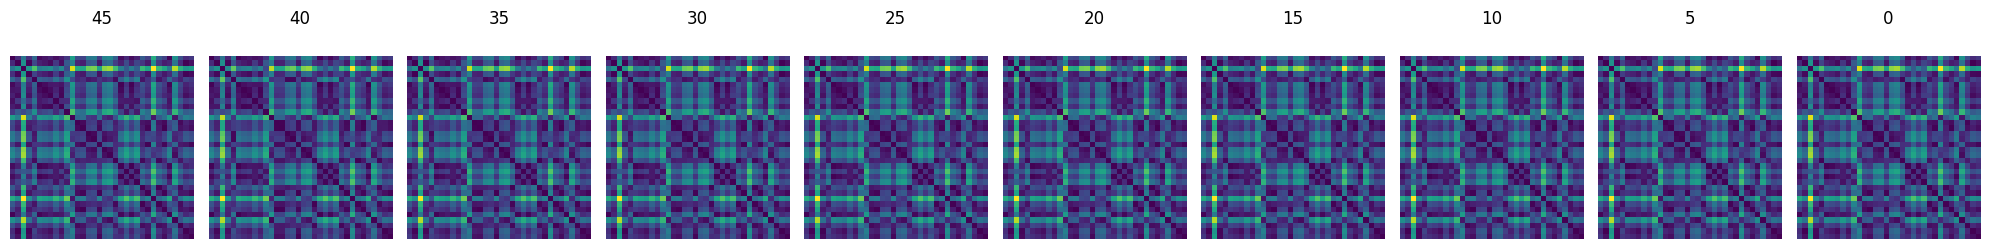

In [22]:
SAMPLE_IDX_IN_BATCH = 0
noise_graphs_all, applied_noise = diff_model.forward_add_noise_to_batch(g_target)
print(noise_graphs_all[0])
plot_graph_adjacency(
    noise_graphs_all[::5],
    list(range(0, STEP_COUNT, 5)),
    figsize=20,
    batch=SAMPLE_IDX_IN_BATCH,
)

full_noise_batch = noise_graphs_all[-1]
full_noise_sample = full_noise_batch.to_data_list()[SAMPLE_IDX_IN_BATCH]
print(full_noise_sample)

applied_noise_sample = applied_noise[SAMPLE_IDX_IN_BATCH : SAMPLE_IDX_IN_BATCH + 1]

denoised_graphs = diff_model.forward_remove_noise(
    applied_noise_sample, full_noise_sample, noise=applied_noise_sample
)
print(denoised_graphs[0])
plot_graph_adjacency(
    denoised_graphs[::5], list(range(0, STEP_COUNT, 5))[::-1], figsize=20
)

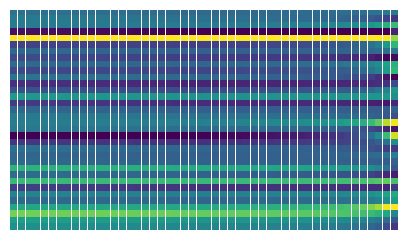

In [23]:
noisy_nodes_all, noise = diff_model.q_sample(g_target.x)
noisy_nodes_all = noisy_nodes_all.permute(3, 0, 1, 2)
plt.figure(figsize=(5, STEP_COUNT * 5))
for img_idx, noisy_node in enumerate(noisy_nodes_all):
    plt.subplot(1, STEP_COUNT, img_idx + 1)
    plt.axis("off")
    plt.imshow(noisy_node[0:1].squeeze(-1).permute(1, 0).cpu().detach().numpy())
plt.show()

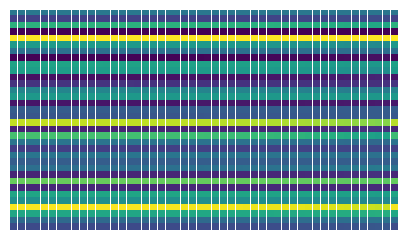

In [24]:
denoised = noisy_nodes_all[-1]
plt.figure(figsize=(5, STEP_COUNT * 5))
for i in range(STEP_COUNT)[::-1]:
    timestep = torch.full((1,), i, device="cuda", dtype=torch.long)
    denoised = diff_model.p_sample(denoised, noise, noise, timestep)
    plt.subplot(1, STEP_COUNT, i + 1)
    plt.axis("off")
    plt.imshow(denoised[0:1].squeeze(-1).permute(1, 0).detach().cpu().numpy())
plt.show()

torch.Size([5])


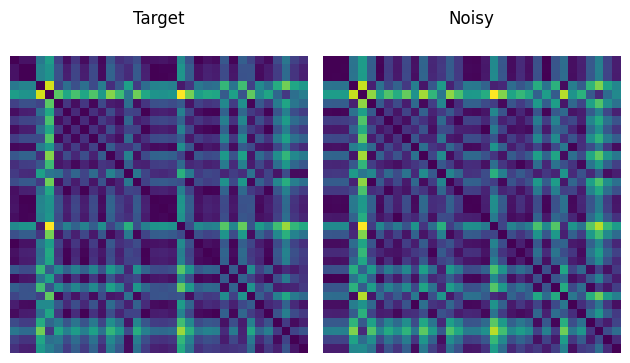

In [26]:
# Currently used diffusion:
diff_model = GraphDiffusion(
    step_count=STEP_COUNT,
    noise_schedule="cosine",
    noise_dist="normal",
    noise_mean=0.0,
    noise_std=0.01,
)
timesteps = torch.randint(
    30, diff_model.step_count, (g_target.x.shape[0],), device="cuda"
).long()
print(timesteps.shape)
noise = diff_model.create_noise_like(g_target.x)
# noisy_nodes, noise = diff_model.q_sample(g_target.x, timesteps, noise)
# print(noisy_nodes)
# print(g_target.x)
noisy_graph = diff_model.q_sample_graph(g_target.x, timesteps, noise)

plot_graph_adjacency([g_target, noisy_graph], ["Target", "Noisy"])